# Plot Training Loss History of Klein-Gordon Problem

We already saved the training loss history in the saved checkpoints.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

Import local packages


In [ ]:


from src.utils.logger import Logging
from src.utils.plot_loss import plot_loss_history
from src.utils.color import model_color

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.


In [ ]:
TANH_NORM_DIST = "./model/a1/klein_tanh_normal_a1.pth"
BSPLINE_DIST = "./model/a1/klein_bspline_a1.pth"
CHEBTSHEV_DIST = "./model/a1/klein_chebyshev_a1.pth"
GRBF_DIST = "./model/a1/klein_grbf_a1.pth"
JACOBI_DIST = "./model/a1/klein_jacobi_a1.pth"
TANH_PARAM_DIST = "./model/a1/klein_tanh_trainable_a1.pth"
FOURIER_DIST = "./model/a1/klein_fourier_a1.pth"


model_path_list = {
    "tanh": TANH_NORM_DIST,
    "param_tanh": TANH_PARAM_DIST,
    "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    "chebyshev": CHEBTSHEV_DIST,
    "jacobi": JACOBI_DIST,
    "fourier": FOURIER_DIST,
}

SOLVER_TO_MODULE = {
    "grbf": "src.nn.grbf",
    "jacobi": "src.nn.jacobi",
    "bspline": "src.nn.bspline",
    "chebyshev": "src.nn.chebyshev",
    "param_tanh": "src.nn.tanh_parameterized",
    "tanh": "src.nn.tanh",
    "fourier": "src.nn.fourier",
}

RESULT = "result/klein_gordon"

Create logger


In [14]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, RESULT)
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

## Plot Training Loss History

I saved the training loss in a pickle file during training so that I can plot it later if needed.


### Load Saved Model


In [ ]:
all_loss_history = {}

for activation, model_path in model_path_list.items():
    logger.print(f"MODEL_PATH {model_path}")

    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")

    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_history = state.get("loss_history")
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")
        model = PINNKAN(model_architecture, model_activation_name).to("cpu")

    model.load_state_dict(state["model_state_dict"])
    logger.print(f"Model {activation} loaded from {model_path}")
    logger.print(f"activation:  , {config.get('activation')}")
    logger.print(f"solver:  , {config.get('solver')}")
    logger.print(f"problem:  , {config.get('problem')}")
    logger.print(f"number of iterations:  , {len(next(iter(loss_history.values())))}")
    logger.print(f"batch size:  , {config.get('batch_size')}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")
    all_loss_history[activation] = loss_history
    for lkey, lvalue in loss_history.items():
        logger.print(f"loss: {lkey} , final loss: {lvalue[-1]:.1e}")

logger.print("file directory:", logger.get_output_dir())

Pre-process the loss data for plotting

```py
all_loss_history = {
    model1: {
        loss1: [],
        loss2: [],
        ...
    },
    model2: {
        loss1: [],
        loss2: [],
        ...
    },
}

# example

all_loss_history = {
    tanh: {
        lbcs: [],
        phy: [],
        ...
    },
    fourier: {
        lbcs: [],
        phy: [],
        ...
    },
}
```


In [ ]:
keys = all_loss_history.keys()
values = all_loss_history.values()

model_summed_loss_dict = {}

for model, loss_dict in zip(keys, values):
    total_loss = np.zeros(
        len(
            next(iter(loss_dict.values()))
        )
    )

    print(f"{model=}, #iter={len(total_loss)}")

    for key in loss_dict:
        if key not in ["lphy"]:
            total_loss += np.array(loss_dict[key])

    model_summed_loss_dict[model] = total_loss

min_length = min([len(x) for x in model_summed_loss_dict.values()])
for key in model_summed_loss_dict:
    model_summed_loss_dict[key] = model_summed_loss_dict[key][0:min_length]

print("Truncated model_summed_loss_dict:", model_summed_loss_dict.keys())
print("Truncated model_summed_loss_dict:", len(model_summed_loss_dict.get("tanh")))

model='tanh', #iter=60001
model='param_tanh', #iter=60001
model='grbf', #iter=60001
model='bspline', #iter=60001
model='chebyshev', #iter=60001
model='jacobi', #iter=60001
model='fourier', #iter=60001
Truncated model_summed_loss_dict: dict_keys(['tanh', 'param_tanh', 'grbf', 'bspline', 'chebyshev', 'jacobi', 'fourier'])
Truncated model_summed_loss_dict: 60001


Plot each model's loss


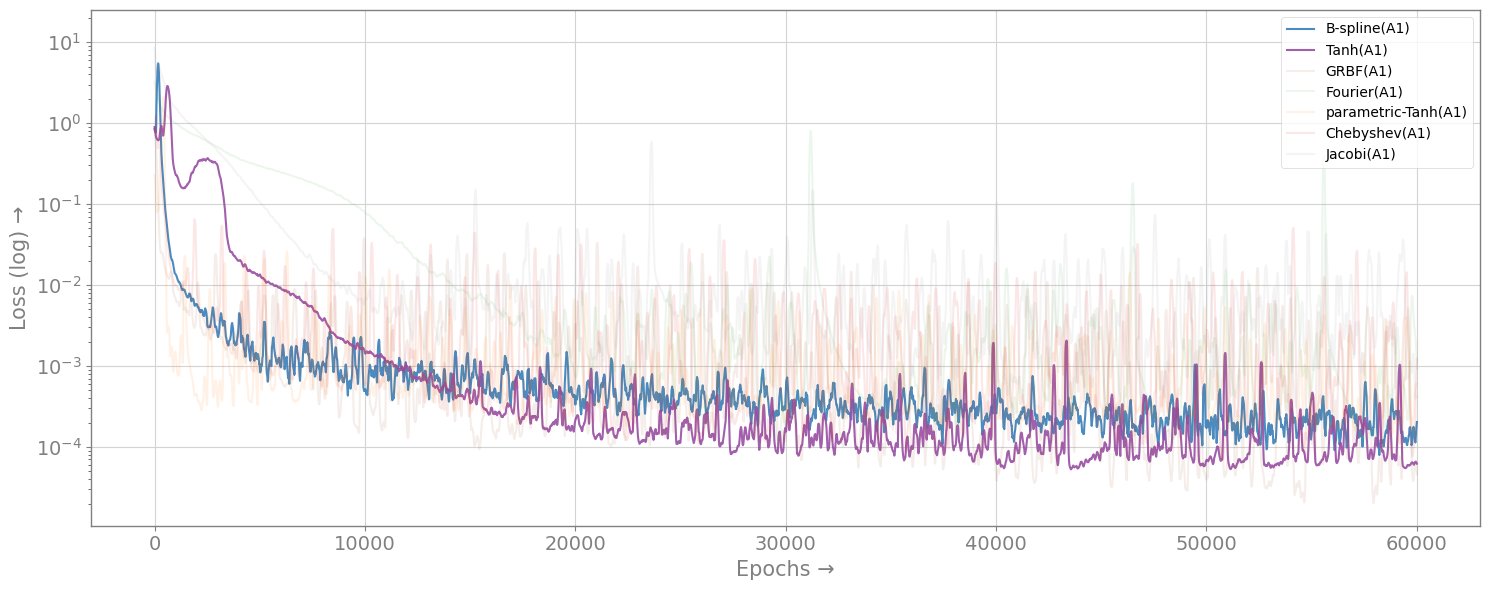

In [8]:
data_list = [
    {
        "data": model_summed_loss_dict["bspline"],
        "color": model_color["bspline"],
        "name": "B-spline(A1)",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["tanh"],
        "color": model_color["tanh"],
        "name": "Tanh(A1)",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["grbf"],
        "color": model_color["grbf"],
        "name": "GRBF(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["fourier"],
        "color": model_color["fourier"],
        "name": "Fourier(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["param_tanh"],
        "color": model_color["param_tanh"],
        "name": "parametric-Tanh(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["chebyshev"],
        "color": model_color["chebyshev"],
        "name": "Chebyshev(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["jacobi"],
        "color": model_color["jacobi"],
        "name": "Jacobi(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
]

plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_klein.png"),
    y_max=25,
)